<a href="https://colab.research.google.com/github/YG15/DataHack2019/blob/master/Yonathan_Aramis_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import packages
import pandas as pd
import numpy as np
import os

# For data visualization:
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

# For model training and inference
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics 
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

In [0]:
# Hide logs and future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# Export Data

In [3]:
url = 'https://armis-datahack.s3.amazonaws.com/all_devices.csv'
devices_df = pd.read_csv(url, index_col = 0)
devices_df.head()

,network_id,device_id,type,model,manufacturer,operating_system,operating_system_version
113,0,1028623,MOBILE_PHONE,Galaxy S8,Samsung,Android,9
587,0,48047,MOBILE_PHONE,Galaxy Note 8,Samsung,Android,9
668,0,123568,MOBILE_PHONE,H918,LG Electronics,Android,8.0.0
830,0,95366,MOBILE_PHONE,iPhone 6,"Apple, Inc.",iOS,NaN
886,0,1755023,TABLET,iPad,Apple,iOS,NaN


In [0]:
url = 'https://armis-datahack.s3.amazonaws.com/all_sessions.csv'
sessions_df = pd.read_csv(url, index_col = 0)
sessions_df.head()

In [0]:
df = pd.merge(sessions_df, devices_df, how = 'left', on='device_id')

# Preliminary data exploration

In [0]:
# Short description of the features
for c in df.columns:
    if raw_df[c].dtype=='object':
        print('{} - is a categorical feature and has {} unique values'.format(c,df[c].nunique()))
    else:
        print('{} - is a continues feature that range between {} and {}'.format(c,df[c].min(),raw_df[c].max()))

#products_in_cart - is a continues feature that range between 0 and 13
#times_visited_website - is a continues feature that range between 0.0 and 10.0
#viewed_ads - is a continues feature that range between 0.0 and 18.0
age - is a continues feature that range between 19.0 and 61.0
delivery_time - is a categorical feature and has 4 unique values
shopper_segment - is a categorical feature and has 3 unique values
tag - is a continues feature that range between 0.0 and 1.0
target_product_category - is a categorical feature and has 42 unique values
target_product_description_length - is a continues feature that range between 8 and 200
target_product_price - is a continues feature that range between 21 and 495
target_product_price_color - is a categorical feature and has 6 unique values
timestamp - is a categorical feature and has 59296 unique values


In [0]:
# Describe
df.describe()

,#products_in_cart,#times_visited_website,#viewed_ads,age,tag,target_product_description_length,target_product_price
count,100000.000000,79844.000000,80093.000000,79911.000000,80000.000000,100000.00000,100000.000000
mean,6.501660,5.002405,10.004345,33.775525,0.259337,103.97777,115.011610
std,1.798002,1.582873,2.232342,6.725314,0.438274,55.71652,119.952501
min,0.000000,0.000000,0.000000,19.000000,0.000000,8.00000,21.000000
25%,5.000000,4.000000,8.000000,29.000000,0.000000,56.00000,41.000000
50%,7.000000,5.000000,10.000000,34.000000,0.000000,104.00000,51.000000
75%,8.000000,6.000000,12.000000,38.000000,1.000000,152.00000,106.000000
max,13.000000,10.000000,18.000000,61.000000,1.000000,200.00000,495.000000


# Engineered features

In [0]:
# Seperate the hour from the timestamp
# Parse time
df['hour']= df.timestamp.apply(lambda x: int(x.split(':')[0]))
df.drop(columns=['timestamp'],inplace=True)

In [0]:
# Set a categorical time range feature
def time_of_day(hour):
    if 1<=hour<20:
        return 'day'
    else:
        return 'night'
df['time_of_day'] = df['purchase_hour'].apply(lambda x : time_of_day(x))

In [0]:
# Unify product category (turn all to lowercase, as some use uppercase while other doesn't)
df['target_product_category'] = df['target_product_category'].apply(lambda x: x.lower())

# Create main product category
df['main_product_category']= df.target_product_category.apply(lambda x: x.split('-')[0])

In [0]:
# Turn categorical columns to dummy variables:
df_dummy = pd.get_dummies(df)
df_dummy.head()

,#products_in_cart,#times_visited_website,#viewed_ads,age,tag,target_product_description_length,target_product_price,purchase_hour,delivery_time_1-3 days,delivery_time_15+ days,...,target_product_price_color_orange,target_product_price_color_pink,target_product_price_color_red,time_of_day_day,time_of_day_night,main_product_category_clothing,main_product_category_gardening,main_product_category_opera tickets,main_product_category_smartphones,main_product_category_video games
0,8,7.0,16.0,25.0,1.0,91,36,17,1,0,...,0,0,1,1,0,0,0,0,0,1
1,6,6.0,10.0,NaN,1.0,157,34,23,0,0,...,0,0,0,0,1,0,0,0,0,1
2,6,7.0,9.0,36.0,0.0,86,36,2,0,1,...,0,0,1,1,0,0,0,0,0,1
3,6,6.0,NaN,32.0,1.0,121,32,8,0,0,...,0,0,1,1,0,0,0,0,0,1
4,8,NaN,8.0,NaN,0.0,85,56,7,0,0,...,0,0,1,1,0,1,0,0,0,0


### Dealing with missing Data
================================================================

One of the major problem of our data is a large amount of missing data, appearing in 3 features

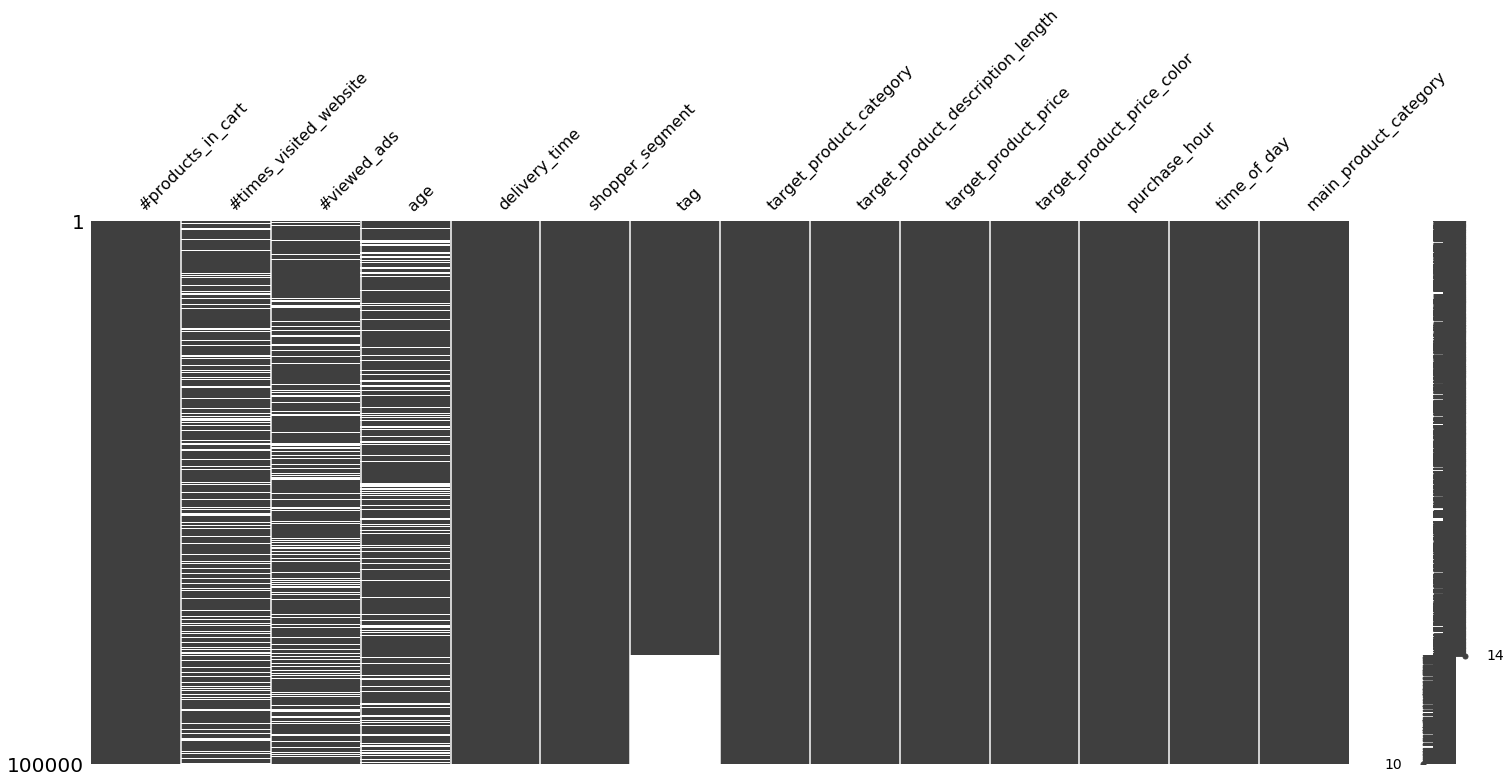

In [0]:
# Missing data visualization
msno.matrix(df);

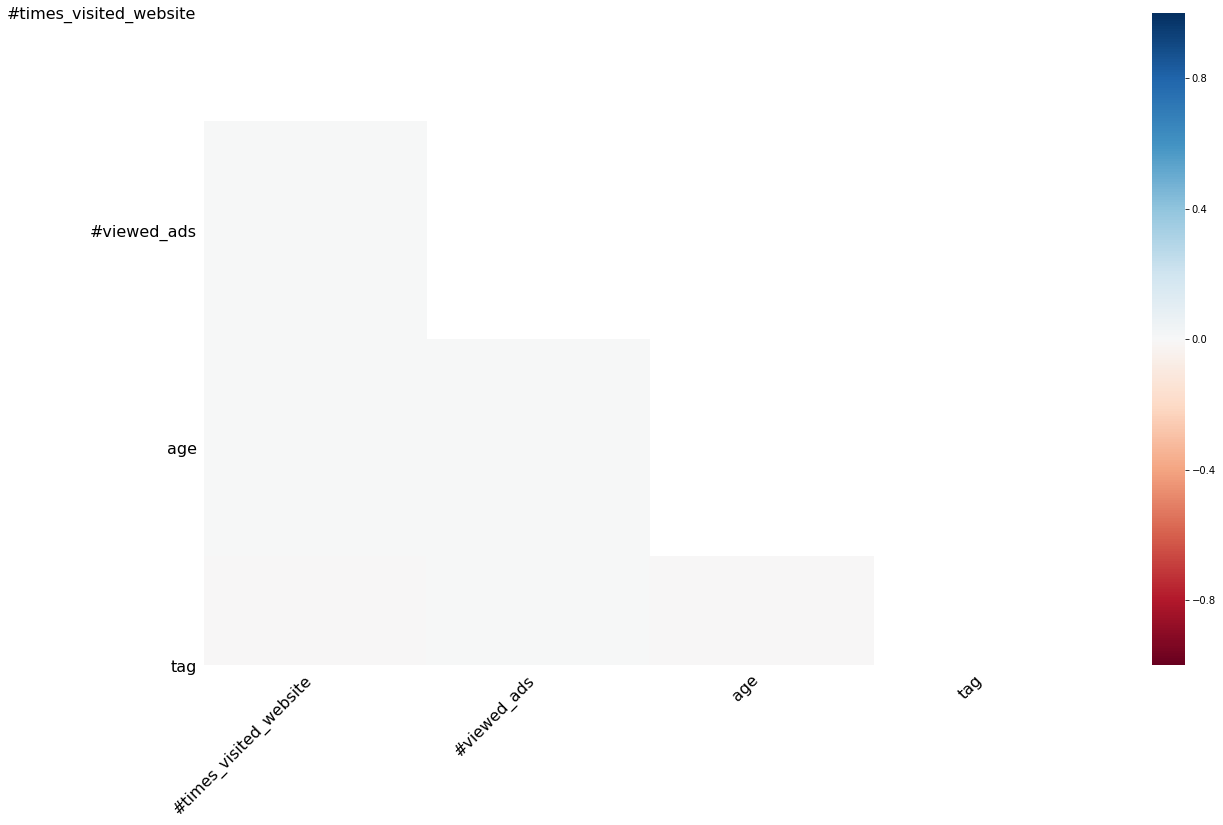

In [0]:
# No correlation between features with missing data
msno.heatmap(df);

In [0]:
# What are the abundance of missing data?
# Percentages of NaN for each column
for c in df.columns:
    if (df[c].isna().sum()>0):
        print('\'{}\' feature has missing values in {}% of the samples'.format(c,df[c].isna().mean().round(4) * 100))
        if c not in ['tag','label']:
            # Create for ean column wiht missing data a dummy features - 'is_nan'
            df[c+'_is_nan']=df[c].apply(lambda x: np.isnan(x)*1)

        
# Count number of missing features in sample and sum it as a feature
df['numbers_of_columns_nan']=  df.isnull().sum(axis=1)

'#times_visited_website' feature has missing values in 20.16% of the samples
'#viewed_ads' feature has missing values in 19.91% of the samples
'age' feature has missing values in 20.09% of the samples
'tag' feature has missing values in 20.0% of the samples


# NaN Imputation
Missing data can be treated in several ways:
1. Be removed - this is problematic since missing data can appear in the test set and we wish to be able to predict those samples too. In addition - Missing data might carry some information which we shouldn't ignore.
2. Treat is a unique value - This allows us to keep the knowledge about the missing data but in continues variable is problematic since some value need to be selected, and without giving the missing data a certain value most models could not use it.
2. Imputation - The missing data can be replaced with a certain value, this can be done in several ways:
    * Replace it with a 0
    * Replace it with some metric (mean/median/mode, etc.)
    * Replace it based on the similarity to known samples (modeling it using KNN, expectation–maximization, MICE)
    
--> Although it seems logic to replace missing data in `age` with the value of the mean (as age tend to have a normal distribution and the mean would be the most likely value to be selected randomly), and `#viewed_ads` and  `#times_visited_website` as 0, this will require an assumption that NaN are divided across the samples randomly, and I don't know that. In fact it is very likely that NaN belongs to a certain sub-group with a different distribution and characteristics. Therefore, I preferred to choose option 3. 

In order to keep the knowledge of the missing data I'll add a dummy column for each missing columns and a summary column for number of missing values (previously added).

In [0]:
# Impute missing data using multivariate imputation using Expectation–Maximization algorithm
X = df_dummy.drop(['tag'], axis=1)
X_columns = X.columns
X = X.as_matrix()
X_imputed = impy.em(X) # impy.fast_knn(X,k=3)
df_dummy_imputed = pd.DataFrame(X_imputed, columns=X_columns)
df_dummy_imputed['label'] = pd.Series(df_dummy['tag'].values)
display(df_dummy_imputed.head())

,#products_in_cart,#times_visited_website,#viewed_ads,age,target_product_description_length,target_product_price,purchase_hour,delivery_time_1-3 days,delivery_time_15+ days,delivery_time_4-8 days,...,target_product_price_color_pink,target_product_price_color_red,time_of_day_day,time_of_day_night,main_product_category_clothing,main_product_category_gardening,main_product_category_opera tickets,main_product_category_smartphones,main_product_category_video games,label
0,8.0,7.000000,16.000000,25.000000,91.0,36.0,17.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,6.0,6.000000,10.000000,31.102204,157.0,34.0,23.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,6.0,7.000000,9.000000,36.000000,86.0,36.0,2.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,6.0,6.000000,13.537683,32.000000,121.0,32.0,8.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,8.0,5.153356,8.000000,34.921944,85.0,56.0,7.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# Round float values (as all values in dataset are integers)
for c in df_dummy_imputed.columns:
    if c!= 'label': 
        df_dummy_imputed[c] = df_dummy_imputed[c].apply(lambda x: round(x))
df_dummy_imputed.head()

,#products_in_cart,#times_visited_website,#viewed_ads,age,target_product_description_length,target_product_price,purchase_hour,delivery_time_1-3 days,delivery_time_15+ days,delivery_time_4-8 days,...,target_product_price_color_pink,target_product_price_color_red,time_of_day_day,time_of_day_night,main_product_category_clothing,main_product_category_gardening,main_product_category_opera tickets,main_product_category_smartphones,main_product_category_video games,label
0,8,7,16,25,91,36,17,1,0,0,...,0,1,1,0,0,0,0,0,1,1.0
1,6,6,10,31,157,34,23,0,0,1,...,0,0,0,1,0,0,0,0,1,1.0
2,6,7,9,36,86,36,2,0,1,0,...,0,1,1,0,0,0,0,0,1,0.0
3,6,6,14,32,121,32,8,0,0,1,...,0,1,1,0,0,0,0,0,1,1.0
4,8,5,8,35,85,56,7,0,0,0,...,0,1,1,0,1,0,0,0,0,0.0


# Exploratory Data Analysis (EDA)

In [0]:
# Extract train data
train_df = df_dummy_imputed[df_dummy_imputed.label.notnull()]
train_df.shape

(80000, 49)

In [0]:
print('We have a total of {} labeled samples with {} features\n{} of the samples did not make a purchase and {} did purchase'.format(
                                                                                                             train_df.shape[0],
                                                                                                             train_df.shape[1],
                                                                                                             sum(train_df.label==0),
                                                                                                             sum(train_df.label==1)))

We have a total of 80000 labeled samples with 49 features
59253 of the samples did not make a purchase and 20747 did purchase


In [0]:
# Seperate to continues and categorical features 
numeric_vars = [col for col,typecol in zip(train_df.columns,train_df.dtypes) if typecol!='object']
continues_vars = [col for col,typecol in zip(train_df.columns,train_df.dtypes) if (typecol!='object') and (train_df[col].nunique()>2)]
boolean_vars = set(numeric_vars).difference(set(continues_vars))
categorical_vars = [col for col,typecol in zip(df.columns,df.dtypes) if typecol=='object']

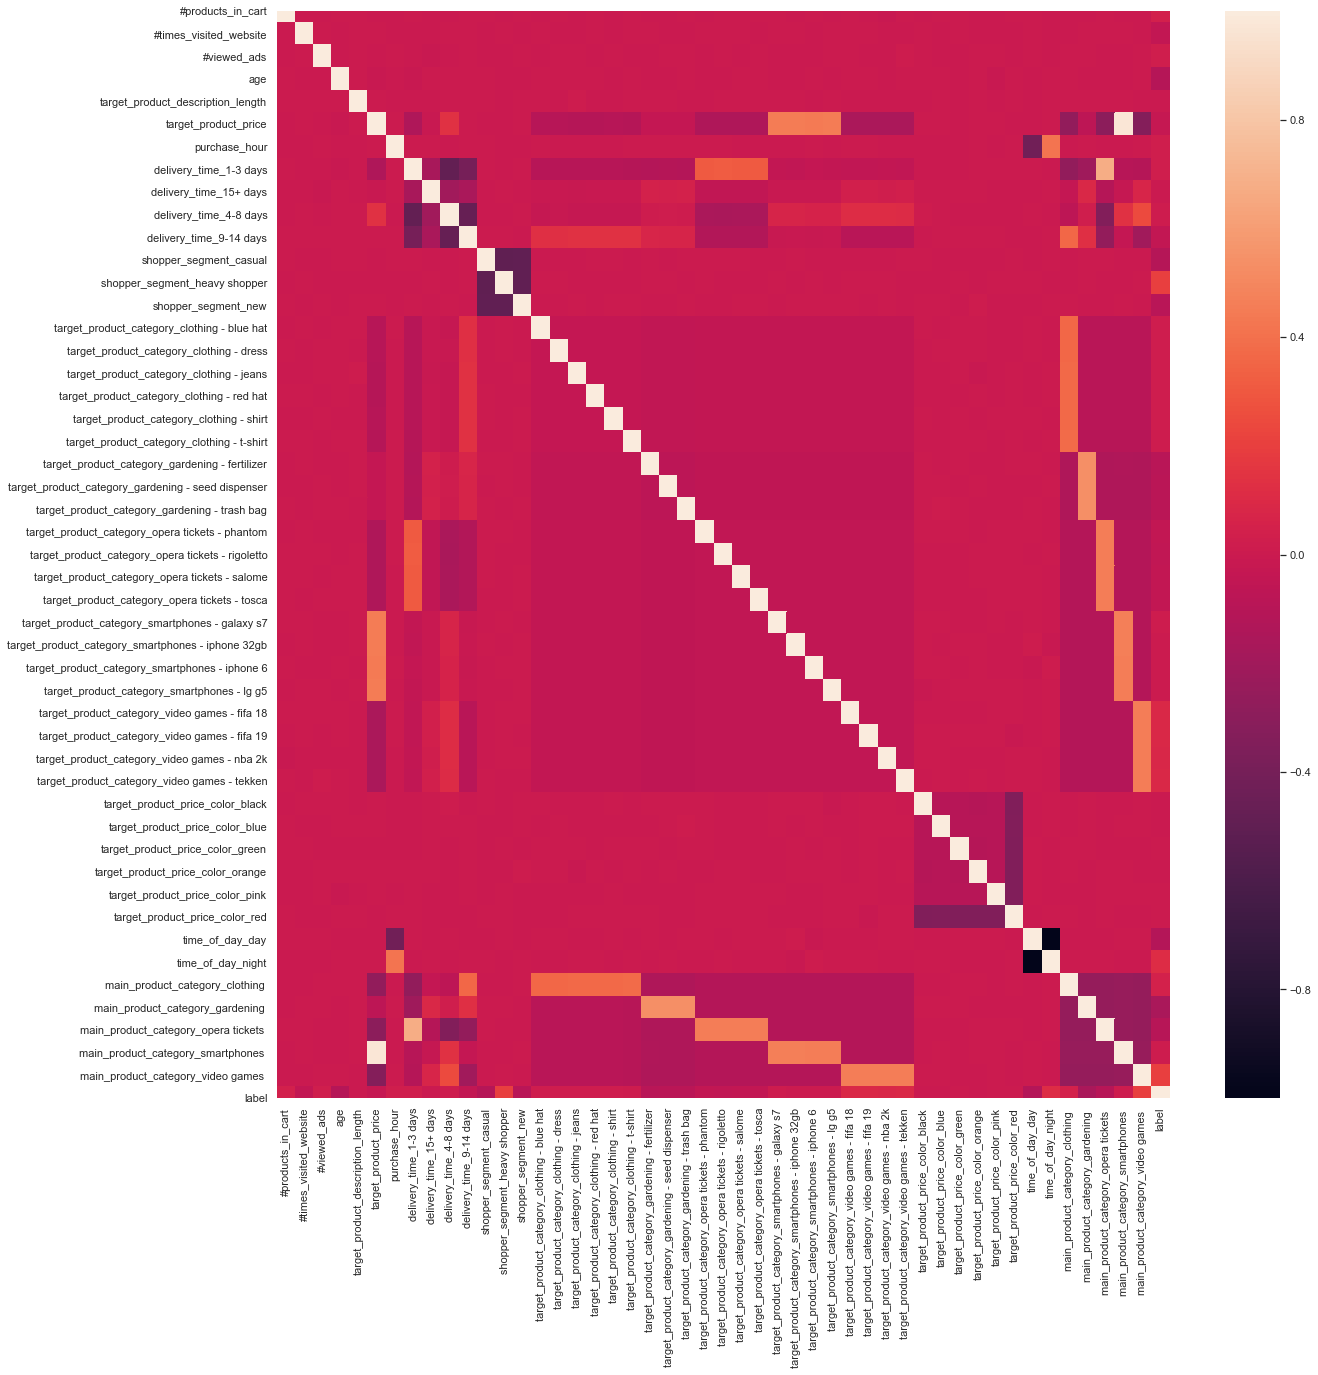

In [0]:
# Correlation between features
sns.set(rc={'figure.figsize':(20,20)})
corr = train_df.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns);

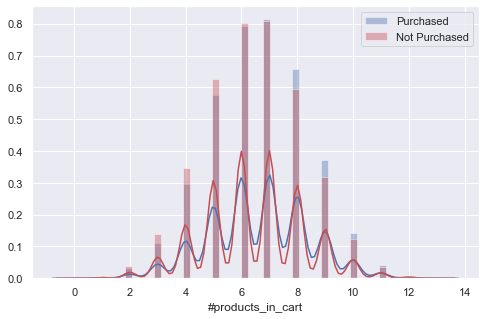

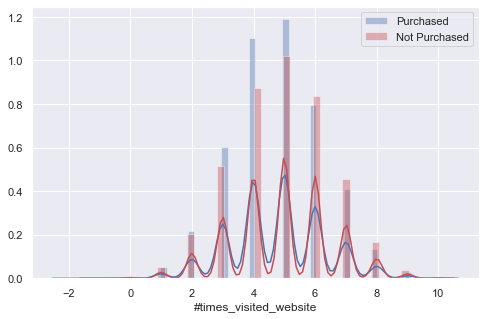

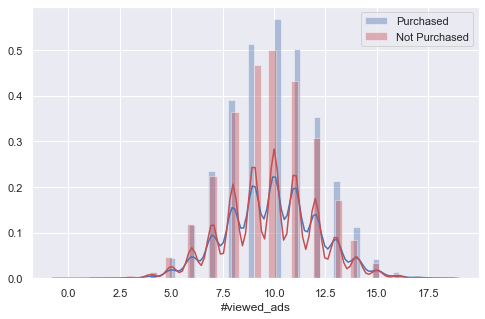

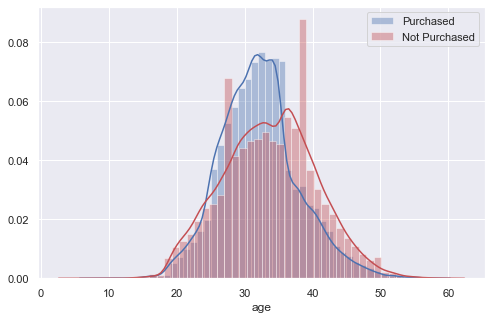

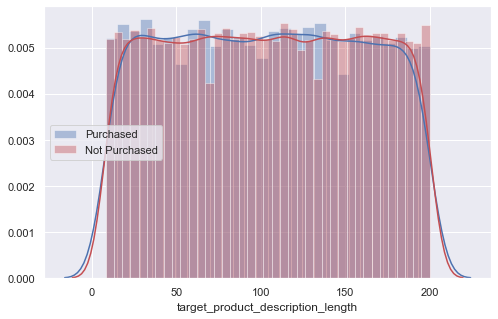

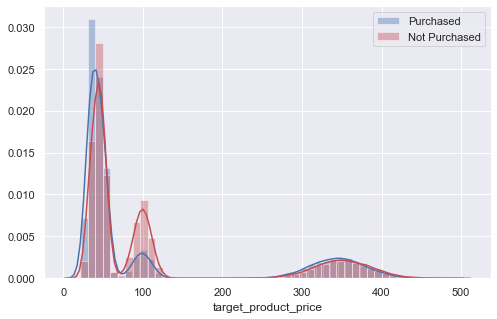

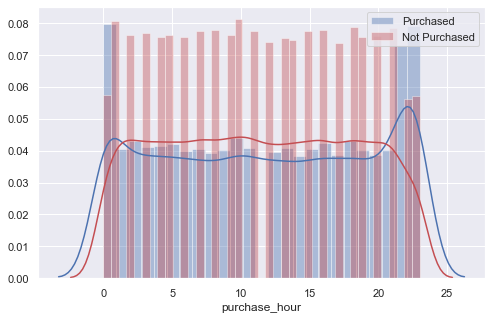

In [0]:
# Compare distribution of the different continues variables for non-purchased and purchased
sns.set(rc={'figure.figsize':(8,5)})
for i,var in enumerate(continues_vars):
    plt.figure(i)   
    sns.distplot(train_df[var][train_df.label==1], label='Purchased', color ='b')
    sns.distplot(train_df[var][train_df.label==0], label='Not Purchased', color ='r')
    plt.legend()

### Insights:
1. Product around 100$ are significantly more often not bought (`target_product_price` feature)
2. Elderly people tend to purchase less (`age` feature)
2. Must purchase are made between 20:00 to 24:00 (`purchase_hour` feature) 

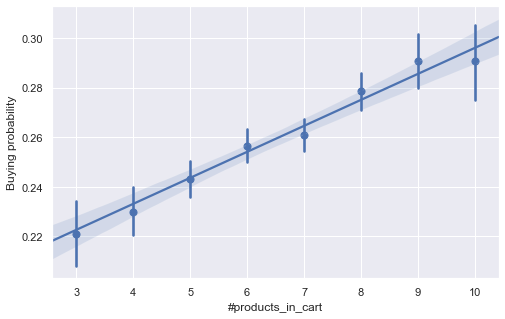

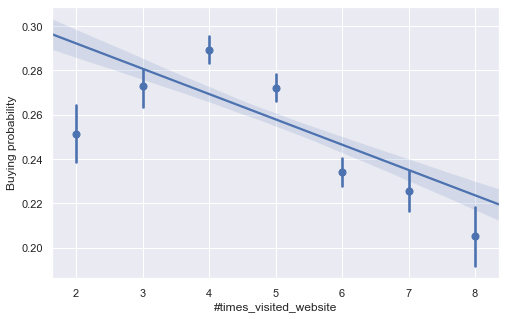

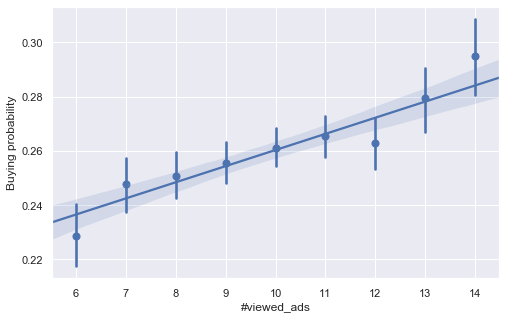

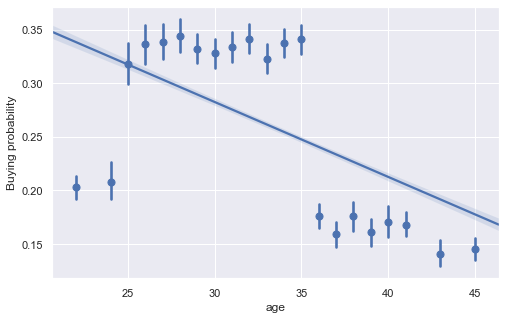

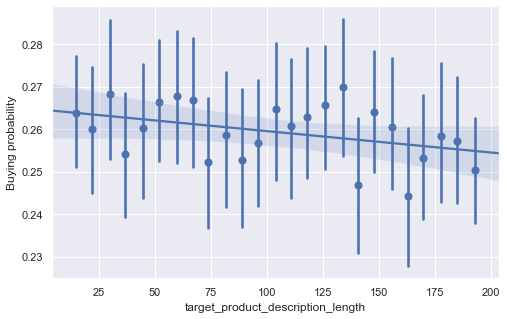

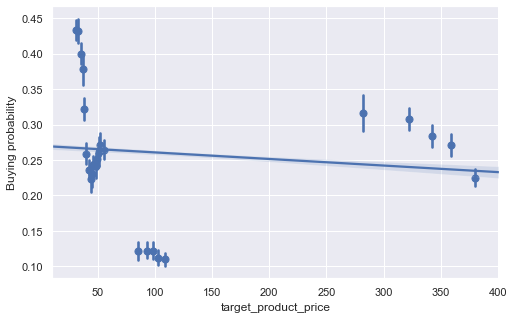

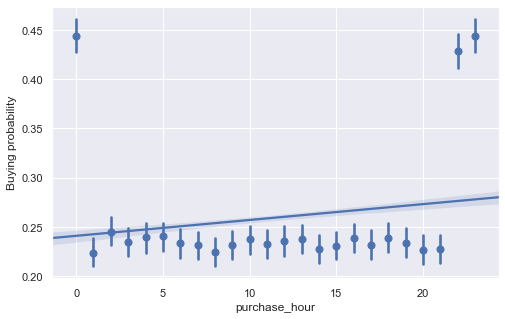

In [0]:
# Regression plot for the continues variables    
for i,var in enumerate(continues_vars):
    plt.figure(i)   
    ax =sns.regplot(data=train_df, x=var, y='label', x_bins=25)
    ax.set( ylabel='Buying probability')

### Insights:
Buying probability tend to:
1. Increase with the number of ads viewed
2. Go up with the first visits, but than decrease with time visited the website
3. Strongly and positively correlate with number of products in cart
4. Strongly decrease with the increase of price, until 100$ and than be a bit higher for much more expensive products
5. Be much higher for people between ages 25-35
6. Be higher during the night
7. Reduce slightly for buyer with unknown data

### A point worth addressing is that even for relatively 'high probability' purchases, the probability doesn't rise above 45% which means that the confidence behind the prediction of a person as 'buyer' wouldn't be high

In [0]:
# Boxplot for the continues variables
if False: # This visualiztion doesn't supply any aditional knowledge
    for i,var in enumerate(continues_vars):
        plt.figure(i)   
        ax =sns.boxplot(data=train_df, x='label', y=var)
        ax.set_xticklabels(['No purchase','Purchased'],rotation=30)

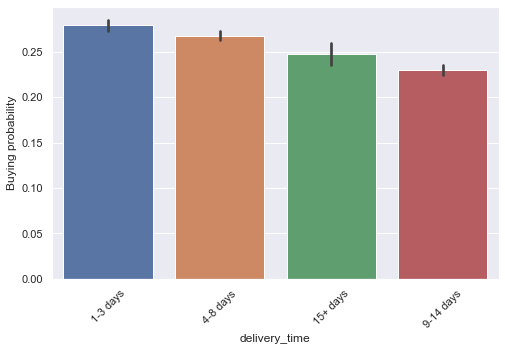

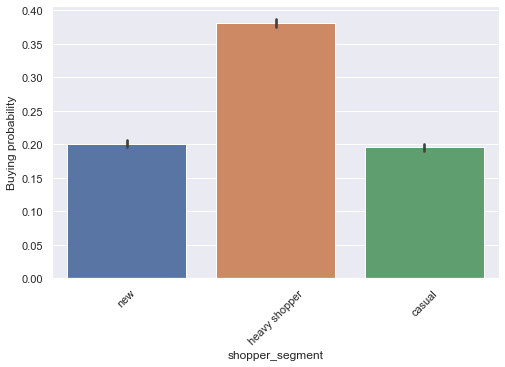

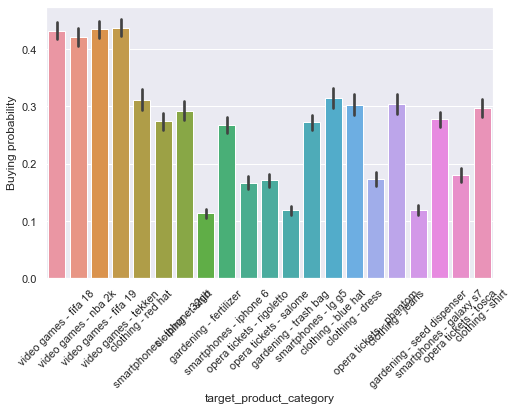

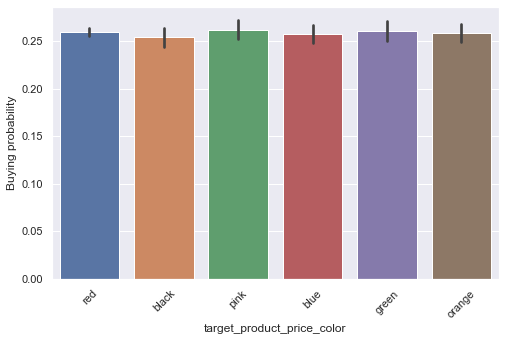

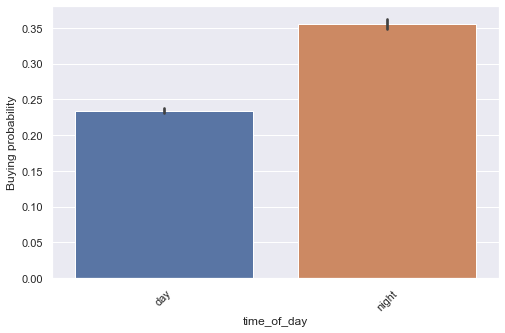

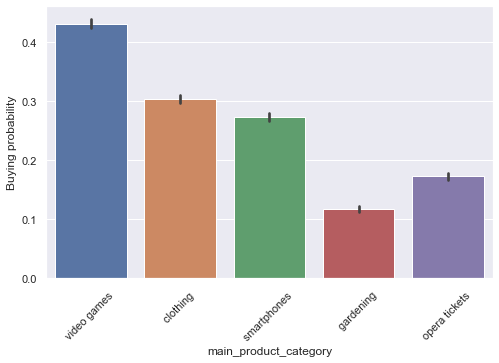

In [0]:
# Compare categorical varaibles
sns.set(rc={'figure.figsize':(8,5)})

for i,var in enumerate(categorical_vars):
    plt.figure(i)   
    ax =sns.barplot(data=df, x=var, y='tag')
    ax.set( ylabel='Buying probability')
    plt.xticks(rotation=45)

### Insights:
1. Heavy shoppers tend to buy more than other (which is logical), there is no significant difference between new and casual buyers
2. The faster the shipping request is, the higher probability for purchase
3. During the the night the probability for purchase is higher than during the day
4. Video games have the highest probability to be purchased while gardening related product - the least

# Model training and inference

In [0]:
# Preprocessing of the data for modelling
X = train_df
for var in ['label','tag']:
    if var in train_df.columns:
        X = X.drop([var], axis=1)
# Save columns names (for assuring that the final test data has the same features)
x_columns = list(X.columns)
X = X.as_matrix()
# Feature  scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

y =  pd.Series(train_df['label'].values)

In [0]:
print('We have a total of {} labeled samples with {} features\n{} of the samples did not make a purchase and {} did purchase at least one product'.format(X.shape[0],
                                                                                                             X.shape[1],
                                                                                                             sum(y==0),
                                                                                                             sum(y==1)))

We have a total of 80000 labeled samples with 48 features
59253 of the samples did not make a purchase and 20747 did purchase at least one product


In [0]:
# Compare 4 different models
seed = 0

lr     = LogisticRegression(random_state=seed, class_weight='balanced')
gnb    = GaussianNB()
rf     = RandomForestClassifier(random_state=seed, class_weight='balanced')
xgbc   = xgb.XGBClassifier(random_state=seed, class_weight='balanced')
models = [lr, gnb, rf, xgbc]


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
skf.get_n_splits(X, y)

models_predict_list = []
models_predict_proba_list = []
for i,model in enumerate(models):
    predict = pd.Series(index= train_df.index)
    predict_proba = pd.Series(index= train_df.index)
    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train,y_train)
        predict.iloc[test_index]=model.predict(X_test)
        predict_proba.iloc[test_index]=model.predict_proba(X_test)[:,1]
    models_predict_list.append(predict)
    models_predict_proba_list.append(predict_proba)
    print('*******************************************************')
    print (str(model).split('(')[0])
    print ('ROC AUC:', round(metrics.roc_auc_score(y, predict_proba),2))   
    print (metrics.classification_report(y, predict, target_names=['Non Purchase','Purchased']) )

*******************************************************
LogisticRegression
ROC AUC: 0.75
              precision    recall  f1-score   support

Non Purchase       0.87      0.69      0.77     59253
   Purchased       0.45      0.71      0.55     20747

    accuracy                           0.70     80000
   macro avg       0.66      0.70      0.66     80000
weighted avg       0.76      0.70      0.71     80000

*******************************************************
GaussianNB
ROC AUC: 0.7
              precision    recall  f1-score   support

Non Purchase       0.85      0.59      0.70     59253
   Purchased       0.38      0.71      0.49     20747

    accuracy                           0.62     80000
   macro avg       0.62      0.65      0.60     80000
weighted avg       0.73      0.62      0.65     80000

*******************************************************
RandomForestClassifier
ROC AUC: 0.78
              precision    recall  f1-score   support

Non Purchase       0.83      

# Error analysis

### Our best Accuracy is  about 10% better than random accuracy (our data is imbalanced, so in case the model would have predicted all samples as 0, we would have received an accuracy of 59253/80000=~74%)

Most error are missed buyers (high false negative - very low recall for purchase)

In [0]:
# Confusion matrix
pd.DataFrame(metrics.confusion_matrix(y, predict), columns= ['Not purchased', 'Purchased'], index = ['Not purchased', 'Purchased'])

,Not purchased,Purchased
Not purchased,56367,2886
Purchased,10334,10413


In [0]:
# Investigate wrong prediction
train_df['predict'] = predict
train_df['correct_prediction']= (train_df.label==train_df.predict)*1

train_df[train_df['correct_prediction']==1].sample(10)

c:\users\guttel\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\guttel\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,#products_in_cart,#times_visited_website,#viewed_ads,age,target_product_description_length,target_product_price,purchase_hour,delivery_time_1-3 days,delivery_time_15+ days,delivery_time_4-8 days,...,time_of_day_day,time_of_day_night,main_product_category_clothing,main_product_category_gardening,main_product_category_opera tickets,main_product_category_smartphones,main_product_category_video games,label,predict,correct_prediction
72013,7,3,9,36,132,95,5,0,0,1,...,1,0,0,1,0,0,0,0.0,0.0,1
26183,6,8,10,34,22,117,10,0,0,1,...,1,0,0,1,0,0,0,0.0,0.0,1
1013,8,8,10,54,102,53,22,0,0,0,...,0,1,1,0,0,0,0,0.0,0.0,1
37066,2,6,10,34,114,114,0,0,0,1,...,0,1,0,1,0,0,0,0.0,0.0,1
69194,5,6,9,30,146,101,4,0,0,0,...,1,0,0,1,0,0,0,0.0,0.0,1
44642,7,6,8,29,24,62,17,0,1,0,...,1,0,1,0,0,0,0,0.0,0.0,1
65054,8,4,13,42,49,333,10,0,0,0,...,1,0,0,0,0,1,0,0.0,0.0,1
52469,8,4,11,29,181,368,2,1,0,0,...,1,0,0,0,0,1,0,1.0,1.0,1
62770,8,4,6,31,69,50,5,0,0,0,...,1,0,1,0,0,0,0,1.0,1.0,1
2268,8,5,7,30,136,51,15,1,0,0,...,1,0,0,0,1,0,0,0.0,0.0,1


# Predict test

In [0]:
# A parameters random search for XGBoost
params = {'min_child_weight': [1, 5, 10],
          'gamma': [0.5, 1, 1.5, 2, 5],
          'subsample': [0.6, 0.8, 1.0],
          'colsample_bytree': [0.6, 0.8, 1.0],
          'max_depth': [3, 4, 5]}

scores = {'AUC': 'roc_auc', 'f1': 'f1', 'Accuracy': 'accuracy'}

xgbc = xgb.XGBClassifier(random_state = seed)

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = seed)

random_search = RandomizedSearchCV(xgbc, 
                                   params, 
                                   n_iter=20,
                                   scoring=scores , 
                                   n_jobs=-1, 
                                   cv=skf.split(X,y), 
                                   verbose=10, 
                                   random_state=seed,
                                   refit = 'Accuracy')

# Here we go
random_search.fit(X, y)
results = random_search.cv_results_
candidate = np.flatnonzero(results['rank_test_Accuracy'] == 1)
print ('ROC AUC:', round(results['mean_test_AUC'][candidate][0],3))
print ('f1-score:', round(results['mean_test_f1'][candidate][0],3)) 
print ('Accuracy:', round(results['mean_test_Accuracy'][candidate][0],3))
#print("Parameters: {0}".format(results['params'][candidate[0]]))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.8min finished


ROC AUC: 0.807
f1-score: 0.665
Accuracy: 0.849


In [0]:
# Extract test data
test_df = df_dummy_imputed[df_dummy_imputed.label.isnull()]
test_df.shape

(20000, 49)

In [0]:
# Predict labels
test_predict = random_search.predict(test_df.drop(['label'], axis=1).as_matrix())

In [0]:
# Save to file
raw_test_df['tag'] = test_predict
raw_test_df.to_csv('interview_dataset_test_with_tags.csv')
with open("paypal_output_test_labels.txt", "w") as f:
    for item in test_predict:
        f.write("%s\n" % int(item))

# Ideas for future Improvement

There are additional basic ways to improve the model performance such as (1) Adding more features to the dataset, and/or understand better the buying process and select and design additional features based on it and (2) Make a more in-depth model comparison and hyper parameters tuning.
Here are few ideas for more features which might help predict more accurately purchasing:
1. Get the text on the product itself and its description and make an NLP analysis
2. Try to identify to user itself and create profile based on typical behavior
3. Adjust the time stamp to the local hour of the buyer (in case it doesn't)
4. Use the date of the purchase, as certain time (before holidays, on weekend, after getting the paycheck) people tend to buy more
5. Maybe people differ on the basis of gender - might be worth an analysis
5. different countries and cities might present a different purchase pattern 
6. So the device from which the visit was made from
7. The URL from which the buyer arrived

There are other technical issues which could make a difference:
* What type of feature scaling to do - if any
* What does nan mean - Should I eliminate high nan abundance features?
* If added more features - do some features selection / features transformation
* Test other models
* Decide what is the most appropriate metric

and many more
